In [22]:
from numpy import asarray, savez_compressed, load
from PIL import Image

from matplotlib import pyplot

from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout

# Display number of available GPUs on the local machine.
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# List locals devices available for TensorFlow.
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

# Enable debug logs for TensorFlow.
# tf.debugging.set_log_device_placement(True)

Num GPUs Available:  1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8726410520661336106
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3134364057
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4853420596156887605
physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [12]:
# https://stackoverflow.com/questions/35859140/remove-transparency-alpha-from-any-image-using-pil
def remove_transparency(im, bg_colour=(255, 255, 255)):
    # Only process if image has transparency (http://stackoverflow.com/a/1963146)
    if im.mode in ('RGBA', 'LA') or (im.mode == 'P' and 'transparency' in im.info):

        # Need to convert to RGBA if LA format due to a bug in PIL (http://stackoverflow.com/a/1963146)
        alpha = im.convert('RGBA').split()[-1]

        # Create a new background image of our matt color.
        # Must be RGBA because paste requires both images have the same format
        # (http://stackoverflow.com/a/8720632  and  http://stackoverflow.com/a/9459208)
        bg = Image.new("RGBA", im.size, bg_colour + (255,))
        bg.paste(im, mask=alpha)
        return bg

    else:
        return im

def preprocess_emojis(emojis_directory, fixed_directory):
    if (not os.path.exists(fixed_directory)):
        os.makedirs(fixed_directory)
    
    emojis = list()

    files = [f for f in os.listdir(emojis_directory) if os.path.isfile(os.path.join(emojis_directory, f))]

    for filename in files:
        image = Image.open(f'{emojis_directory}/{filename}')

        # Remove the transparency from the image
        image = remove_transparency(image)
        
        # Resize the images down to 32x32 pixels.
        # image = image.resize((32, 32))

        image.save(f'{fixed_directory}/{filename}')

        # Convert the image into 'RGB' mode
        image = image.convert('RGB')

def load_emojis(directory):
    emojis = list()

    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

    for filename in files:
        image = Image.open(f'{directory}/{filename}')

        # Convert the image into 'RGB' mode
        image = image.convert('RGB')
        
        pixels = asarray(image)
        emojis.append(pixels)

    return asarray(emojis)

def plot_emojis(emojis, n_cols):
    for i in range(n_cols * n_cols):
        pyplot.subplot(n_cols, n_cols, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(emojis[i])
    pyplot.show()

In [13]:
dir_emojis = 'emojis'
dir_emojis_fixed = 'emojis-fixed'
preprocess_emojis(dir_emojis, dir_emojis_fixed)

emojis = load_emojis(dir_emojis_fixed)

# Save the clean dataset into a compressed file.
savez_compressed('emojis-dataset.npz', emojis)

Loaded:  (619, 72, 72, 3)


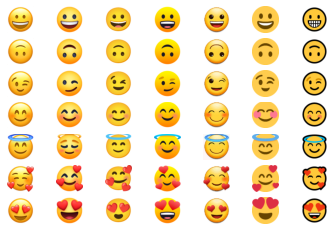

In [14]:
data = load('emojis-dataset.npz')
emojis = data['arr_0']
print('Loaded: ', emojis.shape)
plot_emojis(emojis, 7)

In [15]:
def define_discriminator(in_shape=(72, 72, 3)):
    model = Sequential()
    # Normal
    # model.add(Conv2D(128, (4, 4), activation='relu', padding='same', input_shape=in_shape))
    model.add(Conv2D(128, (4, 4), activation='relu', padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 36x36
    # model.add(Conv2D(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 18x18
    # model.add(Conv2D(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Downsample to 9x9
    # model.add(Conv2D(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(Conv2D(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

def define_generator(latent_dim):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    model = Sequential()
    # Foundation for 9x9 feature maps
    n_nodes = 128 * 9 * 9
    # model.add(Dense(n_nodes, activation='relu', kernel_initializer=init, input_dim=latent_dim))
    model.add(Dense(n_nodes, activation='relu', kernel_initializer=init, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((9, 9, 128)))
    # Upsample to 18x18
    # model.add(Conv2DTranspose(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(Conv2DTranspose(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 36x36
    # model.add(Conv2DTranspose(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(Conv2DTranspose(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Upsample to 72x72
    # model.add(Conv2DTranspose(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(Conv2DTranspose(128, (4, 4), activation='relu', strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    # Output layer at 72x72x3
    model.add(Conv2D(3, (5, 5), activation='tanh', padding='same'))
    return model

def define_gan(d_model, g_model):
    # Freeze the discriminator model's weights from the GAN model
    d_model.trainable = False
    # Connect the discriminator and generator
    model = Sequential()
    # Add the generator
    model.add(g_model)
    # Add the discriminator
    model.add(d_model)
    # Compile the model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [16]:
def load_real_samples():
    data = load('emojis-dataset.npz')
    X = data['arr_0']
    # Convert from unsigned ints to floats
    X = X.astype('float32')
    # Scale from [0, 255] to [-1, 1]
    X = (X - 127.5) / 127.5
    return X

def generate_real_samples(dataset, n_samples):
    # Choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # Retrieve selected images
    X = dataset[ix]
    # Generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

def generate_latent_points(latent_dim, n_samples):
    # Generate points in latent space
    x_input = randn(latent_dim * n_samples)
    # Reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

def generate_fake_samples(g_model, latent_dim, n_samples):
    # Generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # Predict outputs
    X = g_model.predict(x_input)
    # Create 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [17]:
def save_plot(examples, epoch, n=10):
    # Scale from [-1, 1] to [0, 1]
    examples = (examples + 1) / 2.0
    # Plot images
    for i in range(n * n):
        # Define subplot
        pyplot.subplot(n, n, 1 + i)
        # Turn off axis
        pyplot.axis('off')
        # Plot raw pixel data
        pyplot.imshow(examples[i])
    # Save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

def summarize_performance(epoch, d_model, g_model, dataset, latent_dim, n_samples=100):
    # Prepare real samples
    x_real, y_real = generate_real_samples(dataset, n_samples)
    # Evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(x_real, y_real, verbose=0)
    # Prepare fake samples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # Evaluate generator on fake samples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # Summarize discriminator performance
    print('> Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # Save plot
    save_plot(x_fake, epoch)
    # Save the generator model tile file
    filename = 'generator_model_e%03d.h5' % (epoch+1)
    g_model.save(filename)

In [18]:
def train(d_model, g_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            # Get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)
            # Update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)
            # Generate 'fake' samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # Update discriminator model weghts
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
            # Prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # Create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # Update the generator via the discriminator's loss
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # Summarize loss on this batch
            print('> %d, %d/%d, d1=%.3f, d2=%.3f, g=%.3f' %
                (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
        # Evaluate the model performance
        if ((i+1) % 1 == 0):
            summarize_performance(i, d_model, g_model, dataset, latent_dim)

In [21]:
# Size of the latent space
latent_dim = 100
# Create the discriminator
d_model = define_discriminator()
# Create the generator
# g_model = define_generator(latent_dim)
g_model = load_model('generator_model_e078_r5_start.h5')
# Create the GAN
gan_model = define_gan(d_model, g_model)
# Load the emojis
dataset = load_real_samples()
# Train!!!
train(d_model, g_model, gan_model, dataset, latent_dim)

> 1, 1/4, d1=0.683, d2=0.877, g=0.615
> 1, 2/4, d1=0.594, d2=0.834, g=0.626
> 1, 3/4, d1=0.608, d2=0.788, g=0.648
> 1, 4/4, d1=0.630, d2=0.762, g=0.659
> Accuracy real: 100%, fake: 0%
> 2, 1/4, d1=0.694, d2=0.753, g=0.667
> 2, 2/4, d1=0.619, d2=0.747, g=0.670
> 2, 3/4, d1=0.620, d2=0.744, g=0.676
> 2, 4/4, d1=0.611, d2=0.749, g=0.679
> Accuracy real: 91%, fake: 11%
> 3, 1/4, d1=0.684, d2=0.750, g=0.700
> 3, 2/4, d1=0.608, d2=0.712, g=0.742
> 3, 3/4, d1=0.661, d2=0.689, g=0.792
> 3, 4/4, d1=0.662, d2=0.681, g=0.776
> Accuracy real: 43%, fake: 85%
> 4, 1/4, d1=0.672, d2=0.703, g=0.719
> 4, 2/4, d1=0.629, d2=0.729, g=0.698
> 4, 3/4, d1=0.630, d2=0.723, g=0.694
> 4, 4/4, d1=0.652, d2=0.712, g=0.699
> Accuracy real: 75%, fake: 77%
> 5, 1/4, d1=0.653, d2=0.704, g=0.715
> 5, 2/4, d1=0.572, d2=0.695, g=0.726
> 5, 3/4, d1=0.568, d2=0.699, g=0.731
> 5, 4/4, d1=0.545, d2=0.722, g=0.720
> Accuracy real: 93%, fake: 36%
> 6, 1/4, d1=0.616, d2=0.822, g=0.696
> 6, 2/4, d1=0.475, d2=1.055, g=0.665
> 6,